# Introdução

![](https://i.imgur.com/WovuivT.jpg)

O Coronavírus, causador da pandemia global, pertence a uma família de vírus (CoV) que já circula no Brasil. Os vírus dessa família podem causar desde resfriados comuns a doenças mais graves, como a Síndrome Aguda Respiratória Severa (SARS) e a Síndrome Respiratória do Oriente Médio (MERS).

O Novo Coronavírus recebeu a denominação SARS-CoV-2 pela Organização Mundial da Saúde (OMS) e a doença que ele provoca tem a denominação COVID-19.

# Descrição do Modelo

Neste notebook será utilizado o algorítimo ARIMA (Autoregressive Integrated Moving Average models) para realizar um forecast (previsão) do numero de mortes ocorridas no Brasil, em destaque no Estado de São Paulo que até o presente momento concentra a maior parte do numero de mortos do país.

O processo realizado nesse notebook segue o seguinte roteiro:

1. Importação dos dados fornecidos pelo [Ministério da Saúde](https://covid.saude.gov.br/), e a nível municipal, pelo [Brasil.io](https://brasil.io/dataset/covid19/caso/);
2. Análise visual dos dados;
3. Aplicação recursiva para obter os parâmetros SARIMA(p,d,q)(P,D,Q)m adequados ao modelo;
4. Análise de resíduos.
5. Aplicação do algorítimo para se obter índices de autocorrelação e outros critérios;
6. Predição sobre os dados vigentes.
7. Predição sobre possíveis dados futuros.

# Notebook

### Importação de Bibliotecas

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.mlemodel import MLEResults
import datetime

# Tratamento e Visualização dos dados

### No Brasil

In [75]:
#Ultimos 10 dias  de morte no BRASIL!
original_df = pd.read_csv("cases-brazil-states-08-05-2020.csv");
df_br = original_df.filter(['date', 'state', 'deaths']);
df_br = df_br.loc[df_br['state'] == "TOTAL"];

print("Ultimos 10 dias de mortes no Brasil")
print(df_br.tail(10));
print("\n\nGráfico da curva de crescimento das mortes")

fig = px.bar(df_br, x="date", y="deaths", color="deaths", barmode="group")
fig.show()

Ultimos 10 dias de mortes no Brasil
            date  state  deaths
1357  2020-04-29  TOTAL    5537
1385  2020-04-30  TOTAL    5980
1413  2020-05-01  TOTAL    6439
1441  2020-05-02  TOTAL    6810
1469  2020-05-03  TOTAL    7077
1497  2020-05-04  TOTAL    7381
1525  2020-05-05  TOTAL    7972
1553  2020-05-06  TOTAL    8597
1581  2020-05-07  TOTAL    9268
1609  2020-05-08  TOTAL    9960


Gráfico da curva de crescimento das mortes


Através desse gráfico podemos observar que o número de óbitos causados pelo covid-19, em um período de 22 dias, saltou de 1962 mortos para a incrível marca de 9960, ou seja, mais do que quintuplicou suas vítimas.

In [76]:
df = original_df.loc[original_df['date'] == "2020-05-08"];
df = df.loc[df['state'] != "TOTAL"];
df = df.loc[df['deaths'] > 100];
df = df.filter(['state', 'deaths']);
df = df.sort_values(by=['deaths'],ascending=False)

print("\n\nRelação de mortes por estados com mais de 100 mortes")
fig = px.bar(df, x="state", y="deaths", color="state", barmode="group", width=1000)
fig.show()



Relação de mortes por estados com mais de 100 mortes


O Estado de São Paulo concentra o maior número de óbitos ocorridos no Brasil, seguido pelo Rio de Janeiro e Ceara.

### No Estado de São Paulo

In [77]:
#Ultimos 10 dias  de morte no Estado DE SÃO PAULO!
df_sp = original_df.filter(['date', 'state', 'deaths']);
df_sp = df_sp.loc[df_sp['state'] == "SP"];

print("Ultimos 10 dias de Mortes no Estado de São Paulo")
print(df_sp.tail(10));

print("\n\nGráfico da curva de crescimento das mortes")

#foundNull = df_sp['deaths'].isnull().values.any(); #Nenhum valor nulo encontrado


fig = px.bar(df_sp, x="date", y="deaths", color="deaths", barmode="group")
fig.show()

Ultimos 10 dias de Mortes no Estado de São Paulo
            date state  deaths
1355  2020-04-29    SP    2247
1383  2020-04-30    SP    2375
1411  2020-05-01    SP    2511
1439  2020-05-02    SP    2586
1467  2020-05-03    SP    2627
1495  2020-05-04    SP    2654
1523  2020-05-05    SP    2851
1551  2020-05-06    SP    3045
1579  2020-05-07    SP    3206
1607  2020-05-08    SP    3416


Gráfico da curva de crescimento das mortes


O gráfico de mortes do Estado de São Paulo apresenta alguns picos de mortes em dias específicos, causando "saltos" no gráfico.

### Declarando classe auxiliadora

In [78]:
class AnalyticsARIMA():

    # ---------------------------------------------------------------------------
    #   Arima
    # ---------------------------------------------------------------------------

    modelFit:MLEResults = None;
    nomeDaColunaObjetivo = None;
    nomeDaColunaDeDatas = None;

    def arimaDefinirColunaObjetivo(self, nomeDaColunaObjetivo, nomeDaColunaDeDatas, funcaoDeConversaDeDatas=None):
        self.nomeDaColunaObjetivo = nomeDaColunaObjetivo;
        self.nomeDaColunaDeDatas = nomeDaColunaDeDatas;

        if funcaoDeConversaDeDatas is not None:
            self.df[nomeDaColunaDeDatas] = self.df[nomeDaColunaDeDatas].apply(funcaoDeConversaDeDatas);
        else:
            self.df[nomeDaColunaDeDatas] = pd.to_datetime(self.df[nomeDaColunaDeDatas])

        self.df = self.df.groupby(nomeDaColunaDeDatas)[nomeDaColunaObjetivo].sum().reset_index()
        self.df = self.df.set_index(nomeDaColunaDeDatas)

    #Atenção, o dataFrame precisa estar AGRUPADO e ORDENADO
    def plotarDecomposicao(self, dataFrame=None, theModel='addtive', theFigsize = None, theFreq = None):
        from pylab import rcParams;
        import statsmodels.api as sm;
        rcParams['figure.figsize'] = 18, 8;

        if dataFrame is None:
            dataFrame = self.df;

        # Dois tipos de modelos possíves, Aditivo e Multiplicativo (Necessário testar as diferenças)
        if theFreq is not None:
            decomposicao = sm.tsa.seasonal_decompose(dataFrame, model=theModel, freq=theFreq);
        else:
            decomposicao = sm.tsa.seasonal_decompose(dataFrame, model=theModel);
        if theFigsize is not None:
            plt.figure(figsize=theFigsize)
        decomposicao.plot();


    #ARIMA_SASONALIDADE == 12 meses, no caso, 1 ano;
    def aplicarARIMA(self, ARIMA_SASONALIDADE = 12, verbose = False):

        if verbose:
            print('# ===============================================================');
            print('# Preparando quantidade de treino.');
            print('# ===============================================================');

        import itertools;
        p = sazonalidade = range(0, 2);  # Arima P == auto-regressive part of the model
        d = tendencia = range(0, 2);  # Arima D == integrated part of the model
        q = ruido = range(0, 2);  # Arima Q == moving average part of the model

        # itertools.product basicamente relaciona todas as variáveis com todas as varíaveis... como já diz, PRODUCT
        pdq = list(itertools.product(sazonalidade, tendencia, ruido));

        # Criando agora as variações de calculos para o arima usar.
        # (Similar ao 'grid search' de machine learning)
        seasonal_pdq = [(x[0], x[1], x[2], ARIMA_SASONALIDADE) for x in list(itertools.product(p, d, q))];

        if verbose == True:
            print(seasonal_pdq);

        if verbose:
            print('# ===============================================================');
            print('# Escolhendo a melhor combinação de parametros arima.');
            print('# ===============================================================');

        import warnings;
        warnings.filterwarnings("ignore")  # Negócio chato pacas...

        menorCombinacao = None;
        menorCombinacaoValor = 99999999999999999;  # Mesma coisa que Integer.MAX_VALUE

        import statsmodels.api as sm;

        for parametro in pdq:
            for parametro_sasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(self.df,
                                                    order=parametro,
                                                    seasonal_order=parametro_sasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)

                    resultado = mod.fit(disp=0)#disp == 0 Oculta log indesejado que trava o programa....

                    if resultado.aic < menorCombinacaoValor:
                        menorCombinacao = [parametro, parametro_sasonal, ARIMA_SASONALIDADE];
                        menorCombinacaoValor = resultado.aic;

                    if verbose == True:
                        print('ARIMA{}x{}x{} - AIC:{}'.format(parametro, parametro_sasonal, ARIMA_SASONALIDADE, resultado.aic))

                except:
                    # Algumas combinações são NaN (Não são possíveis! por isso tem esse TryCath)
                    continue

        if verbose == True:
            print('\n\n')
            print('O menor valor encontrado para o AIC é: {}'.format(menorCombinacaoValor))
            print('Utilizando a combinação: ARIMA{}x{}x{}'.format(menorCombinacao[0], menorCombinacao[1], menorCombinacao[2]))

        theOrder = menorCombinacao[0];
        theSeasonal_order = menorCombinacao[1];

        if verbose:
            print('# ===============================================================');
            print('# Ajustando Modelo.');
            print('# ===============================================================');

        mod = sm.tsa.statespace.SARIMAX(self.df,
                                        order=theOrder,
                                        seasonal_order=theSeasonal_order,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        self.modelFit = mod.fit(disp=0)#disp == 0 Oculta log indesejado que trava o programa....
        print('\n\n');
        print(self.modelFit.summary().tables[1])

    def diagnostico(self):
        self.modelFit.plot_diagnostics(figsize=(15, 12))
        plt.show()

    def ARIMAPrediction(self, forecastStartingDate = None ,datasetStartDate = None, theFigsize = (14, 7)):

        if datasetStartDate == None:
            datasetStartDate = self.df.index[0];

        if forecastStartingDate == None:
            forecastStartingDate = self.df.index[0];

        # Predição propriamente dita
        pred = self.modelFit.get_prediction(start=pd.to_datetime(forecastStartingDate), dynamic=False)
        pred_ci = pred.conf_int()

        ax = self.df[datasetStartDate:].plot(label='Observado')
        pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=theFigsize)


        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel(self.nomeDaColunaDeDatas)
        ax.set_ylabel(self.nomeDaColunaObjetivo)
        plt.legend()
        plt.show()

    def ARIMAForecast(self, steps, datasetStartDate = None, theFigsize = (14, 7), verbose = False):

        if datasetStartDate == None:
            datasetStartDate = self.df.index[0];

        pred_uc = self.modelFit.get_forecast(steps=steps)

        if verbose is True:
            print(pred_uc.predicted_mean)

        pred_ci = pred_uc.conf_int()

        ax = self.df[datasetStartDate:].plot(label='Observado')
        pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=theFigsize)

        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel(self.nomeDaColunaDeDatas)
        ax.set_ylabel(self.nomeDaColunaObjetivo)
        plt.legend()
        plt.show()

    def ARIMAPredictionToPred(self, forecastStartingDate = None ,datasetStartDate = None):

        if datasetStartDate == None:
            datasetStartDate = self.df.index[0];

        if forecastStartingDate == None:
            forecastStartingDate = self.df.index[0];

        # Predição propriamente dita
        pred = self.modelFit.get_prediction(start=pd.to_datetime(forecastStartingDate), dynamic=False)
        return pred;

    def ARIMAForecastToPred(self, steps, datasetStartDate = None, verbose = False):

        if datasetStartDate == None:
            datasetStartDate = self.df.index[0];

        pred = self.modelFit.get_forecast(steps=steps)

        if verbose is True:
            print(pred.predicted_mean)

        return pred;

    def correlacao(self):
        plot_acf(self.df,lags=50,title="Autocorrelação")

    def correlacao_parcial(self):
        plot_pacf(self.df,lags=50,title="Autocorrelação Parcial")

# Aplicando ARIMA

O modelo ARIMA é aplicando utilizando a classe auxiliadora declarada acima.

## No Brasil

In [79]:
print("Aplicando ARIMA para os dados nacionais")
analytics_br = AnalyticsARIMA();
analytics_br.df = df_br;
analytics_br.arimaDefinirColunaObjetivo(nomeDaColunaObjetivo='deaths', nomeDaColunaDeDatas='date')
analytics_br.aplicarARIMA(verbose=True);

Aplicando ARIMA para os dados nacionais
# ===============================================================
# Preparando quantidade de treino.
# ===============================================================
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
# ===============================================================
# Escolhendo a melhor combinação de parametros arima.
# ===============================================================
ARIMA(0, 0, 0)x(0, 0, 0, 12)x12 - AIC:1387.4544612883426
ARIMA(0, 0, 0)x(0, 0, 1, 12)x12 - AIC:1131.4640984932441
ARIMA(0, 0, 0)x(0, 1, 0, 12)x12 - AIC:1109.8749371442336
ARIMA(0, 0, 0)x(0, 1, 1, 12)x12 - AIC:874.5531463554825
ARIMA(0, 0, 0)x(1, 0, 0, 12)x12 - AIC:937.4843387866459
ARIMA(0, 0, 0)x(1, 0, 1, 12)x12 - AIC:902.6403257635525
ARIMA(0, 0, 0)x(1, 1, 0, 12)x12 - AIC:739.8625616981928
ARIMA(0, 0, 0)x(1, 1, 1, 12)x12 - AIC:724.8528014145882
ARIMA(0, 0, 1)x(0, 0, 0, 12)x12 - A

O algorítimo realiza a aplicação do modelo ARIMA com diferentes pesos para as variáveis p,d,q. Dentre os resultados obtidos, aquele que possui o menor AIC (Akaike Information Critera) é mantido como parâmetro final.

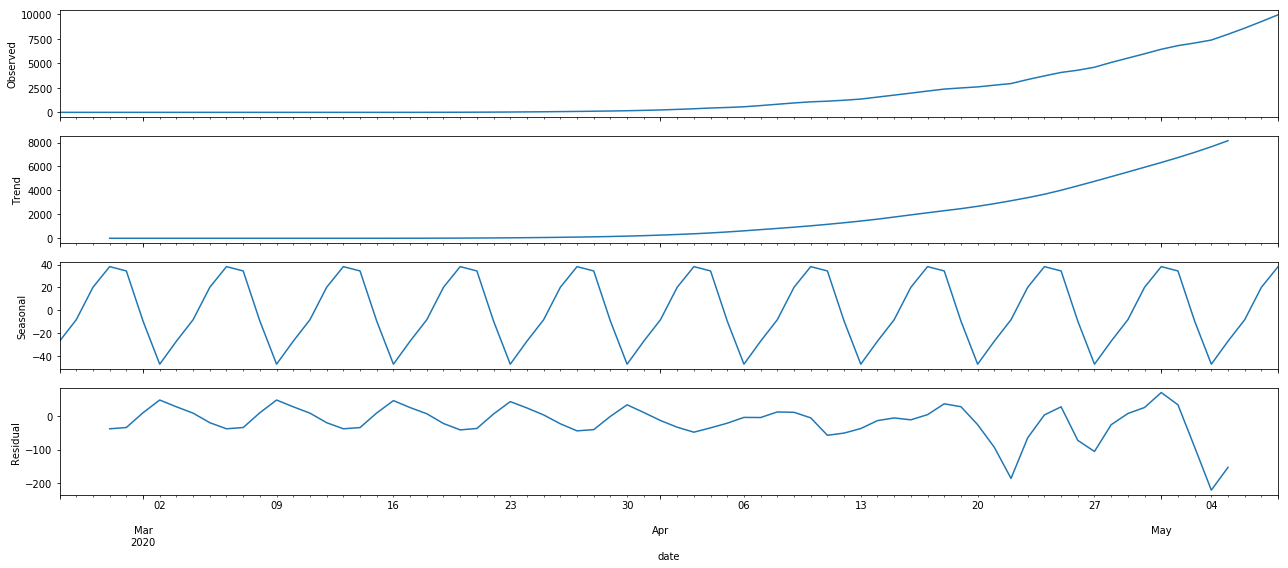

In [80]:
analytics_br.plotarDecomposicao()

Ao observar as tendencias, vemos que a curva tende a subir.

Mesmo que o algorítimo identifique uma sazonalidade aproximada, o tempo decorrido dês de o inicio da pandemia é muito curto para que esses valores tenham um peso relevante.

Ao observar o resíduo do modelo, podemos observar que os dados inicias da óbitos seguiam um padrão aproximado, contudo, a partir de abril os dados passaram a crescer de forma mais heterogênea.

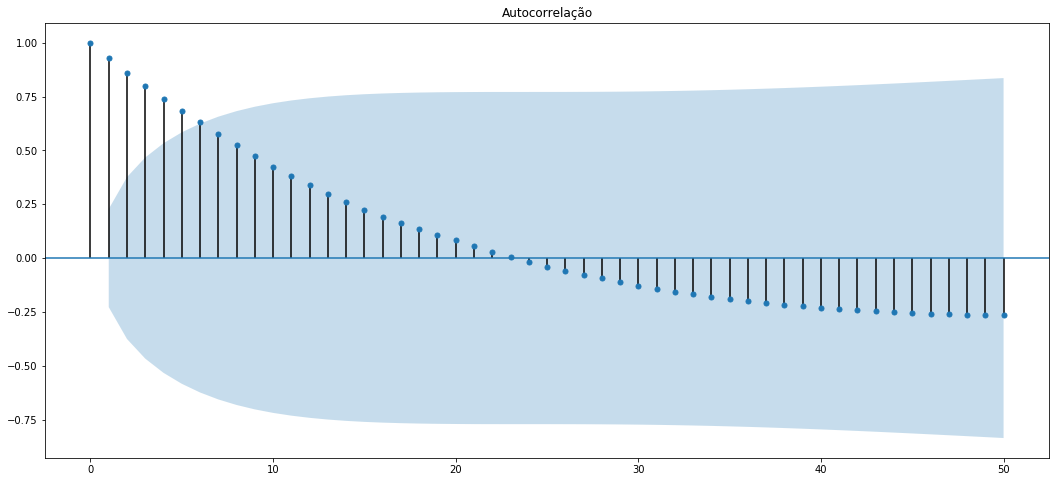

In [81]:
analytics_br.correlacao();

É possível observar por meio do Gráfico de Autocorrelação que de fato existe uma autocorrelação entre o crescimento dos óbitos por dia.

Em vista que se trata de uma serie aparentemente estacionaria e de crescimento homogêneo, de fato é possível obter resultados promissores com o algorítimo ARIMA.

## No Estado de São Paulo

In [82]:
print("Aplicando ARIMA para os dados do Estado de São Paulo")
analytics_sp = AnalyticsARIMA();
analytics_sp.df = df_sp;
analytics_sp.arimaDefinirColunaObjetivo(nomeDaColunaObjetivo='deaths', nomeDaColunaDeDatas='date')
analytics_sp.aplicarARIMA(verbose=True);

Aplicando ARIMA para os dados do Estado de São Paulo
# ===============================================================
# Preparando quantidade de treino.
# ===============================================================
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
# ===============================================================
# Escolhendo a melhor combinação de parametros arima.
# ===============================================================
ARIMA(0, 0, 0)x(0, 0, 0, 12)x12 - AIC:1244.1044808760482
ARIMA(0, 0, 0)x(0, 0, 1, 12)x12 - AIC:1020.3449419974919
ARIMA(0, 0, 0)x(0, 1, 0, 12)x12 - AIC:981.9312528358946
ARIMA(0, 0, 0)x(0, 1, 1, 12)x12 - AIC:774.1238943827541
ARIMA(0, 0, 0)x(1, 0, 0, 12)x12 - AIC:831.0993890702744
ARIMA(0, 0, 0)x(1, 0, 1, 12)x12 - AIC:813.2462783609005
ARIMA(0, 0, 0)x(1, 1, 0, 12)x12 - AIC:668.36370573009
ARIMA(0, 0, 0)x(1, 1, 1, 12)x12 - AIC:657.7697340171319
ARIMA(0, 0, 1)x(0, 0, 0, 

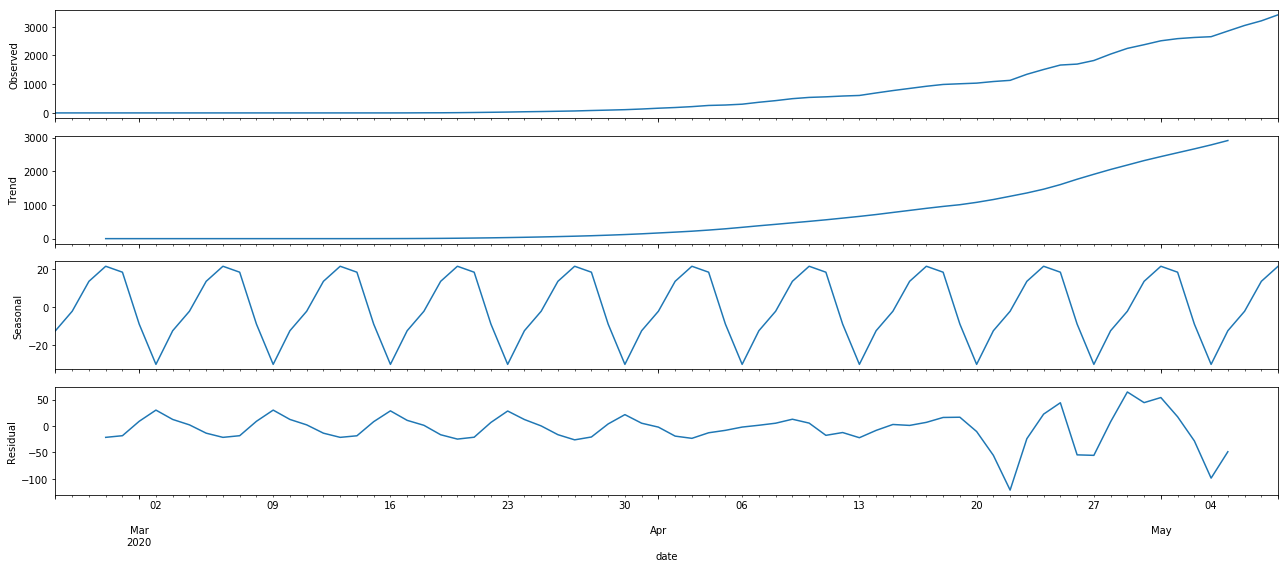

In [83]:
analytics_sp.plotarDecomposicao()

É possível observar que o ruído também está bem presente nos dados analisados do Estado de São Paulo, inclusive, isso é um leve indicador de que os ruídos presentes nas análises a nível nacional tenham sido influenciados por esses dados.

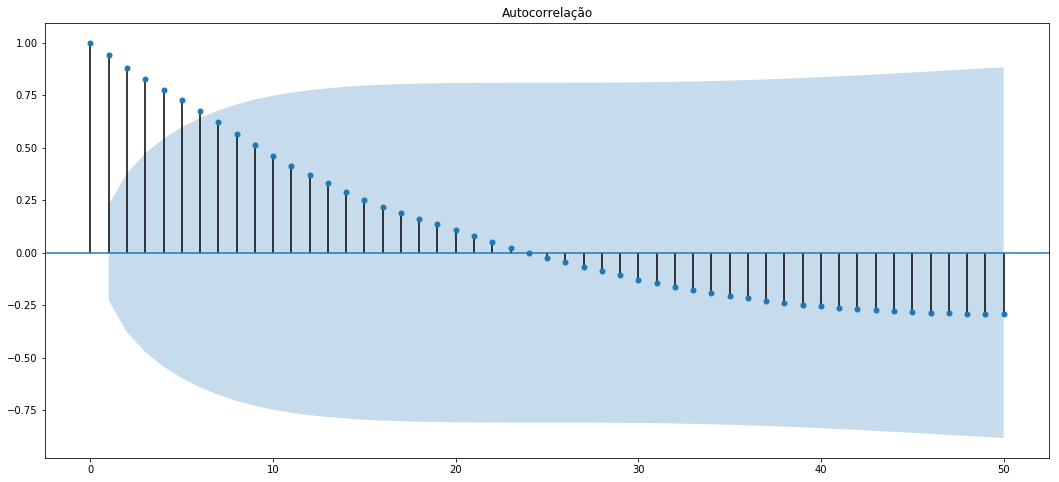

In [84]:
analytics_sp.correlacao();

Os dados do Estado de São Paulo também apresentam um alto índice de autocorrelação.

## Forecast (Previsão)

É importante salientar que o ARIMA não é um modelo matemático criado especificamente para a análise de propagação de doenças, inclusive existem diversos outros modelos matemáticos específicos para isso.

Alem disso, sem saber o "final" da curva, não é possível estipular até quando os óbitos irão subir, por essa razão, o forecast do ARIMA deve ser olhado como uma previsão de curto prazo.

Por meio de alguns testes, foi utilizado a SAZONALIDADE de 12 (um ano) para o treinamento do modelo ARIMA, tendo em vista que com esse período o índice AIC foi o menor encontrado.

### Forecast BRASIL

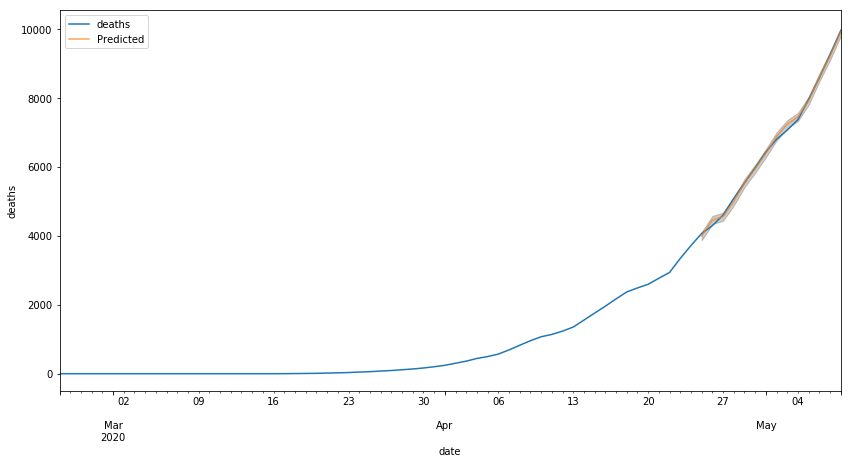

In [85]:
analytics_br.ARIMAPrediction("25-04-2020")

Simulação com treino e teste, utlizando como teste a partir de 25-04-2020

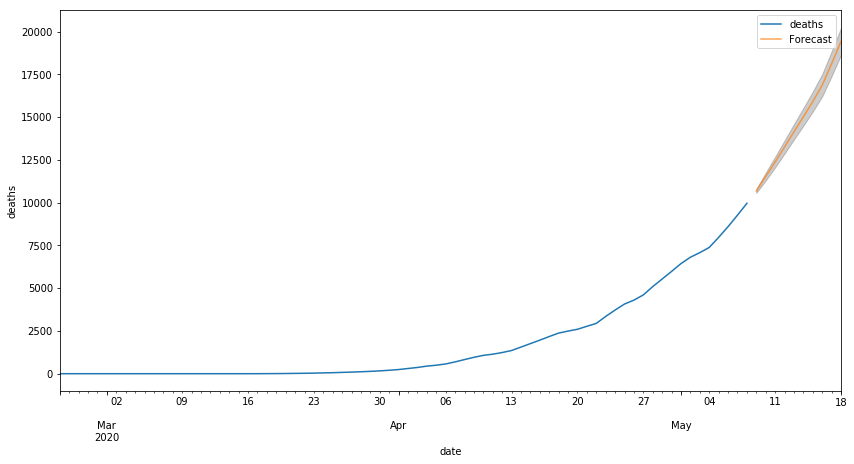

In [86]:
analytics_br.ARIMAForecast(steps=10)

Predição de 10 Dias a frente

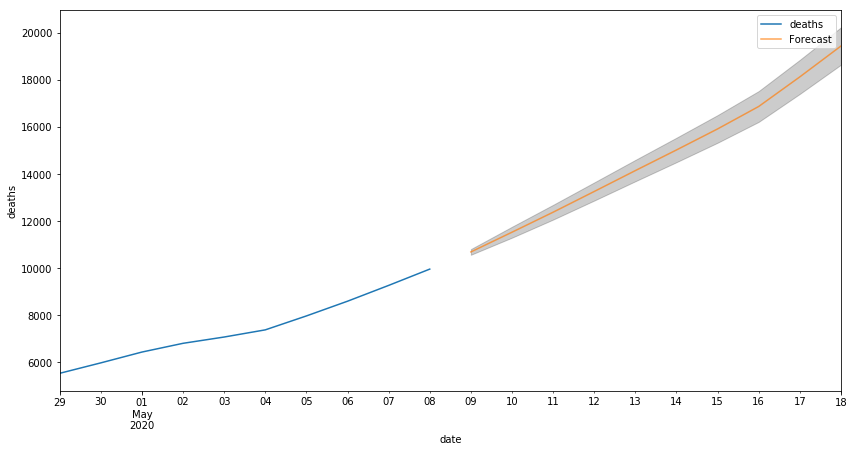

In [87]:
df = analytics_br.df;
df_ultimos_10 = df.tail(10);
analytics_br.df = df_ultimos_10;
analytics_br.ARIMAForecast(steps=10)
analytics_br.df = df; #Voltando dataset ao normal

In [88]:
pred = analytics_br.ARIMAForecastToPred(steps=10)
pred.conf_int()

,lower deaths,upper deaths
2020-05-09,10567.970282,10809.174328
2020-05-10,11294.226918,11757.405357
2020-05-11,12061.730694,12687.834147
2020-05-12,12869.123145,13639.476994
2020-05-13,13687.913464,14594.605163
2020-05-14,14497.067098,15537.073866
2020-05-15,15322.934130,16496.044599
2020-05-16,16208.505275,17516.383617
2020-05-17,17395.571701,18841.275598
2020-05-18,18633.252879,20220.964673


Zoom nos últimos 10 dias e nos novos 10 dias, alem de melhor visualização dos intervalos de confiança.

Nota: O intervalo de confiança é de 95%

In [89]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_ultimos_10.index, y=df_ultimos_10['deaths'], name="Real"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=pred.predicted_mean.index, y=pred.predicted_mean, name="Predição"),
    secondary_y=True,
)
fig.update_layout(
    title_text="Forecast Brasil 08-05-2020 - 10 steps ahead"
)
fig.update_xaxes(title_text="Data")
fig.update_yaxes(title_text="<b>Real</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Predição</b>", secondary_y=True)
fig.show()

### Forecast São Paulo

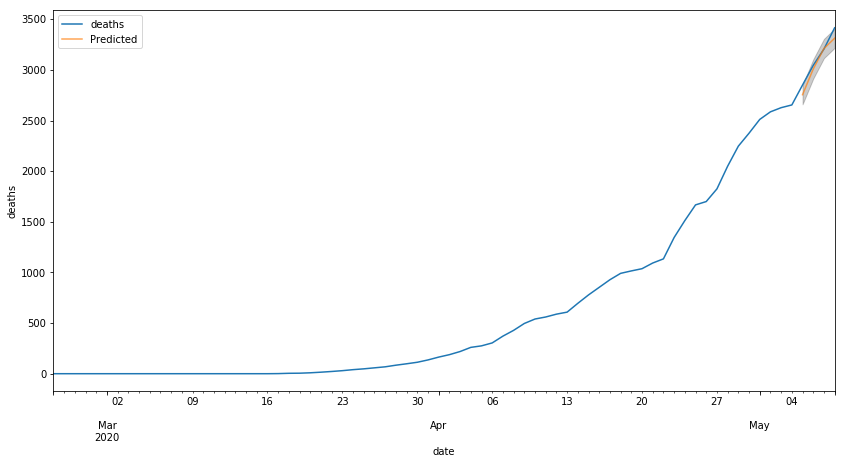

In [90]:
analytics_sp.ARIMAPrediction("05-05-2020")

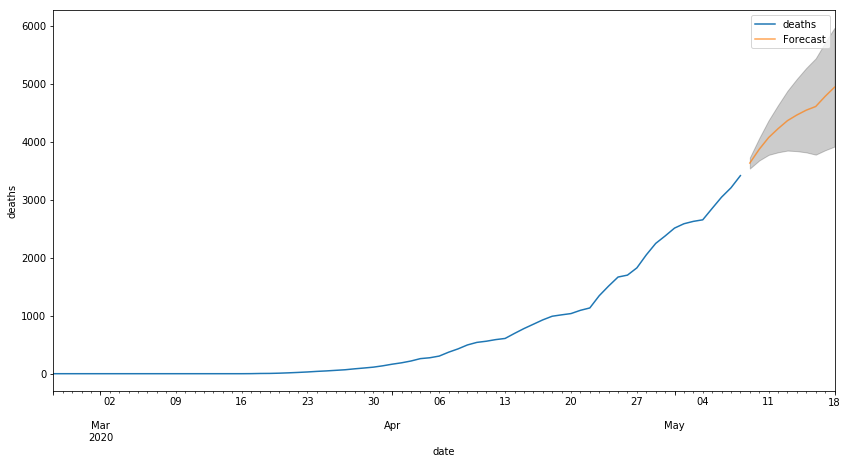

In [91]:
analytics_sp.ARIMAForecast(steps=10)

Predição de 10 Dias a frente

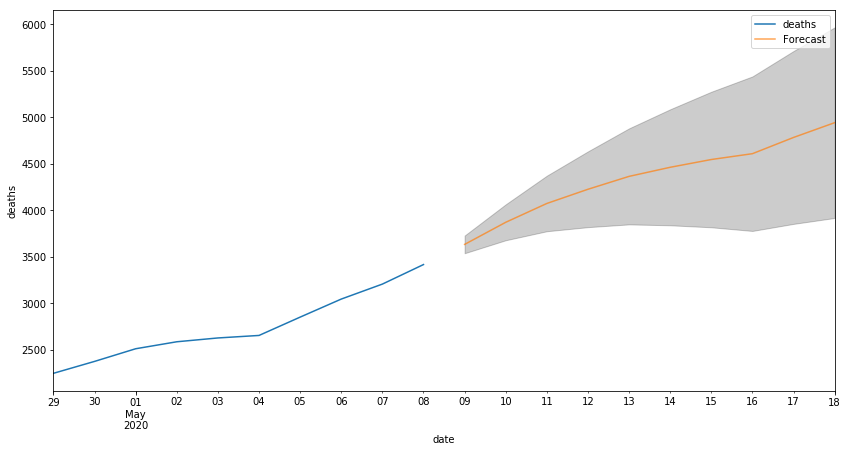

In [92]:
df = analytics_sp.df;
df_ultimos_10 = df.tail(10);
analytics_sp.df = df_ultimos_10;
analytics_sp.ARIMAForecast(steps=10)
analytics_sp.df = df; #Voltando dataset ao normal

In [93]:
pred = analytics_sp.ARIMAForecastToPred(steps=10)
pred.conf_int()

,lower deaths,upper deaths
2020-05-09,3537.745281,3727.716728
2020-05-10,3677.277474,4063.437127
2020-05-11,3774.032077,4371.493543
2020-05-12,3818.024354,4632.724749
2020-05-13,3847.780213,4880.150326
2020-05-14,3838.082791,5085.240499
2020-05-15,3816.646397,5273.735173
2020-05-16,3777.340419,5438.374397
2020-05-17,3853.150334,5711.559090
2020-05-18,3916.710796,5965.693594


Zoom nos últimos 10 dias e nos novos 10 dias, alem de melhor visualização dos intervalos de confiança.

Nota: O intervalo de confiança é de 95%

In [94]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_ultimos_10.index, y=df_ultimos_10['deaths'], name="Real"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter(x=pred.predicted_mean.index, y=pred.predicted_mean, name="Predição"),
    secondary_y=True,
)
fig.update_layout(
    title_text="Forecast Estado de São Paulo 08-05-2020 - 10 steps ahead"
)
fig.update_xaxes(title_text="Data")
fig.update_yaxes(title_text="<b>Real</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Predição</b>", secondary_y=True)
fig.show()

